<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# QLoRA with HuggingFace


QLoRA is an extension of LoRA that leverages quantization. Quantization is the process of mapping continuous infinite values to a smaller set of discrete finite values. Effectively, the model's parameters are are stored in 2, 3, 4 or 8-bits as opposed to the usual 32-bits, lowering the number of bits needed to store information. Quantization offers two benefits:

1. It reduced memory footprint. By using a finite set of discrete levels, the values can be represented with fewer bits, reducing the memory required to store them; and
2. It allows for efficient computation. Quantized values can be represented and processed more efficiently on hardware with limited numerical precision, such as low-power microcontrollers or specialized AI/ML accelerators.

Choosing QLoRA over LoRA provides several tradeoffs. QLoRA offers the following advantages of LoRA:

1. Substantially smaller GPU memory usage than LoRA.
2. Higher maximum sequence lengths resulting from the smaller GPU memory usage.
3. Higher batch sizes resulting from the smaller GPU memory usage.

The main disadvantage of QLoRA is slower fine-tuning speed.

Interestingly enough, the accuracy of QLoRA and LoRA are comparable despite the fact that QLoRA offers substantially smaller models with lower GPU memory footprints than LoRA.

The original QLoRA paper is available [here](https://arxiv.org/pdf/2305.14314).


**Note that the following uses the popular `BitsAndBytes` library to implement QLoRA, which only supports quantization using a CUDA-enabled GPU. You will not be able to run this notebook without a compatible GPU!**

# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Install-required-libraries">Install required libraries</a></li>
            <li><a href="#Import-required-libraries">Import required libraries</a></li>
            <li><a href="#Define-helper-functions">Define helper functions</a></li>
        </ol>
    </li>
    <li><a href="#IMDB-dataset">IMDB dataset</a></li>
    <li><a href="#Tokenizer">Tokenizer</a></li>
    <li><a href="#Configure-BitsAndBytes">Configure BitsAndBytes</a></li>
    <li><a href="#Load-a-quantized-version-of-a-pretrained-model">Load a quantized version of a pretrained model</a></li>
    <li><a href="#Train">Train</a></li>
    <li><a href="#Results">Results</a></li>
</ol>


---


# Objectives

After completing this lab you will be able to:

- Load and predict using models from HuggingFace
- Fine-tune language models using QLoRA
- Understand the advantages and disadvantages of QLoRA



---


# Setup


### Install required libraries

For this lab, you use the following libraries, which are __not__ preinstalled in the Skills Network Labs environment. __You must run the code in the following cell__ to install them.


In [1]:
!pip install -U datasets==2.20.0 huggingface_hub==0.23.4 transformers==4.41.2 peft==0.11.1 bitsandbytes==0.43.1 matplotlib==3.9.0 scikit-learn==1.5.0

# Install known working versions
!pip uninstall triton bitsandbytes transformers -y
!pip install transformers==4.36.2 bitsandbytes==0.41.1 triton==2.1.0


# Then restart your runtime/kernel
print("done")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 102.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 204.5 MB/s eta 0:00:01
ERROR: Operation cancelled by user
Found existing installation: triton 3.2.0
Uninstalling triton-3.2.0:
  Successfully un

In [2]:
# First, clean up any existing installations
!pip uninstall triton bitsandbytes transformers peft -y

# Install compatible versions for Python 3.11 + CUDA 12.4
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

# Core ML packages - compatible versions
!pip install transformers==4.41.2
!pip install bitsandbytes==0.43.1  # This version supports CUDA 12.4
!pip install peft==0.11.1
!pip install triton==2.3.0  # Compatible with CUDA 12.4

# Data and utility packages (these are fine as-is)
!pip install datasets==2.20.0
!pip install huggingface_hub==0.23.4
!pip install matplotlib==3.9.0
!pip install scikit-learn==1.5.0

print("Installation complete - please restart your runtime!")

Found existing installation: triton 2.1.0
Uninstalling triton-2.1.0:
  Successfully uninstalled triton-2.1.0
Found existing installation: bitsandbytes 0.41.1
Uninstalling bitsandbytes-0.41.1:
  Successfully uninstalled bitsandbytes-0.41.1
Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: peft 0.15.2
Uninstalling peft-0.15.2:
  Successfully uninstalled peft-0.15.2
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11

  Using cached scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Installation complete - please restart your runtime!


### Import required libraries

The following code imports required libraries.


In [1]:
import torch
import matplotlib.pyplot as plt
# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import json

import numpy as np

from datasets import load_dataset, load_metric

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig

from peft import LoraConfig, get_peft_model, TaskType, replace_lora_weights_loftq, prepare_model_for_kbit_training

Let's check whether a compatible GPU is available:


In [2]:
# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Define helper functions

Here are some helper functions. We will use these later to save and load from JSON:


In [3]:
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")


def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

# IMDB dataset

The IMDB dataset is a large movie review dataset, consisting of 50,000 movie reviews for training and 25,000 movie reviews for testing. The reviews are labeled as either positive or negative, and each review is a variable-length sequence of words. The IMDB dataset is a popular benchmark for text classification tasks, and it has been used to train a variety of natural language processing models. The following line loads the IMDB dataset:


In [4]:
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Let's display the structure of the IMDB dataset:


In [5]:
# Display the structure of the dataset
print("Dataset structure:")
print(imdb)

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


The following displays the available splits in the dataset (train, test, unsupervised)


In [6]:
imdb.keys()

dict_keys(['train', 'test', 'unsupervised'])

Let's explore and print a sample from the training set:


In [7]:
# Explore and print a sample from the training set
print("\nSample from the training set:")
print(imdb['train'][0])


Sample from the training set:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and n

The followiong displays the unique class labels in the dataset. For the IMDB dataset, the labels are integers representing sentiment, where 0 stands for “negative” and 1 stands for “positive”. Here’s how you can extract this information:


In [8]:
train_labels = imdb['train']['label']
unique_labels = set(train_labels)
print("\nUnique labels in the dataset (class information):")
print(unique_labels)


Unique labels in the dataset (class information):
{0, 1}


The following dictionary maps class values to class names:


In [9]:
class_names = {0: "negative", 1: "positive"}
class_names

{0: 'negative', 1: 'positive'}

Since the IMDB dataset is quite large, we’ll create smaller subsets to facilitate quicker training and testing.

In this notebook, we simulate training and testing using the `small_` datasets due to time constraints. However, it's important to recognize that these smaller datasets are insufficient for proper fine-tuning of the DistilBERT model. For more accurate results, a larger subsample, such as the `medium_train_dataset`, would be necessary.

Consequently, all results presented here pertain to models trained with the `medium_train_dataset` and evaluated on the test set from `medium_test_dataset`. However, the notebook, as is, does NOT train models on these datasets; rather, it trains models using the `small_` datasets, as training on the `medium_` datasets would be too time-consuming.


In [10]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(50))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(50))])
medium_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
medium_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

# Tokenizer

The following loads the DistilBERT tokenizer:    


In [11]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The tokenizer provides tokenized input IDs and an attention mask for a given input text:


In [12]:
my_tokens=tokenizer(imdb['train'][0]['text'])

# Print the tokenized input IDs
print("Input IDs:", my_tokens['input_ids'])

# Print the attention mask
print("Attention Mask:", my_tokens['attention_mask'])

# If token_type_ids is present, print it
if 'token_type_ids' in my_tokens:
    print("Token Type IDs:", my_tokens['token_type_ids'])

Input IDs: [101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 3836, 

The following preprocessing function tokenizes a text input. We apply this function to all texts in our datasets using the `.map()` method:


In [13]:
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

small_tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
small_tokenized_test = small_test_dataset.map(preprocess_function, batched=True)
medium_tokenized_train = medium_train_dataset.map(preprocess_function, batched=True)
medium_tokenized_test = medium_test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Run the following to see what a sample from the tokenized dataset looks like. Note that this dataset is identical to the original, with just the token indices and attention mask appended.


In [14]:
print(small_tokenized_train[49])

{'text': 'With no affinity towards any type of filmmaking, and a healthy appreciation of documentaries, I can honestly say I was angry at myself for bothering to sit through the entire length of "20 Dates". I won\'t waste your time with the plot, you may read other reviews. I will say though that Berkowitz\'s hyper, Woody Allen-style narration was extremely annoying. You either wished he\'d lay off the coffee or ingest some tranquilizers. And it\'s potentially apparent to Berkowitz himself that this film was a bad idea, as parts of it details his trials to finance the documentary. Forgive me for disguising insults as compliments, but I\'ll give credit to Berkowitz for having the skills to convince some idiot to finance this horrid piece of ****. I appreciate the boundaries & intentions of the film here, but even when regarding the standards Berkowitz sets for himself, he fires off and misses on all levels. In closing, I\'m sure many of these female companions were not at ease going on 

The following defines the `compute_metrics` funcion to evaluate model performance using accuracy:


In [15]:
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy", trust_remote_code=True)


   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}


---


# Configure BitsAndBytes


The following code creates a `BitsAndBytes` config object where we define the quantization parameters. Every line in that config is commented to inform you of its function:


In [16]:
config_bnb = BitsAndBytesConfig(
    load_in_4bit=True, # quantize the model to 4-bits when you load it
    bnb_4bit_quant_type="nf4", # use a special 4-bit data type for weights initialized from a normal distribution
    bnb_4bit_use_double_quant=True, # nested quantization scheme to quantize the already quantized weights
    bnb_4bit_compute_dtype=torch.bfloat16, # use bfloat16 for faster computation
    llm_int8_skip_modules=["classifier", "pre_classifier"] #  Don't convert the "classifier" and "pre_classifier" layers to 8-bit
)

# Load a quantized version of a pretrained model


The following code creates two lists. The first list (`id2label`) maps ids to text labels for the two classes in this problem, and the second list (`label2id`) swaps the keys and the values to map the text labels to the ids:


In [17]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = dict((v,k) for k,v in id2label.items())

In [19]:
import torch
import gc

# Clear GPU memory cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

# Reset CUDA context (if needed)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()

print("CUDA cache cleared")
print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

CUDA cache cleared
GPU memory allocated: 0.00 MB
GPU memory cached: 0.00 MB


The following instantiates an `AutoModelForSequenceClassification` from a pre-trained `distilbert-base-uncased` model using the `BitsAndBytesConfig` defined above and the id to label and label to id mappings. The `quantization_config` parameter in particular indicates that a quantized version of the model should be loaded, with the quantization settings contained in the config object passed to `quantization_config`


In [18]:
model_qlora = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                                 id2label=id2label,
                                                                 label2id=label2id,
                                                                 num_labels=2,
                                                                 quantization_config=config_bnb
                                                                )

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: `.to` is not supported for `4-bit` or `8-bit` bitsandbytes models. Please use the model as it is, since the model has already been set to the correct devices and casted to the correct `dtype`.

`model_qlora` is now a quantized instance of the model, but the model is not ready for quantized training just yet. This is accomplished by passing the model through the `prepare_model_for_kbit_training()` function:


In [19]:
model_qlora = prepare_model_for_kbit_training(model_qlora)

NameError: name 'model_qlora' is not defined

Despite its name, `model_qlora` is not a LoRA or QLoRA object yet, but a quantized instance of a pre-trained `distilbert-base-uncased` model that has been made ready for quantized training. To allow this model to be fine-tuned using QLoRA, we must convert the linear layers into LoRA layers. This is done analogously to the way LoRA is applied to a non-quantized model:


In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Specify the task type as sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate
    target_modules=['q_lin','k_lin','v_lin'] # which modules
)

peft_model_qlora = get_peft_model(model_qlora, lora_config)

`peft_model_qlora` is now a QLoRA model which we can go ahead and train. However, before doing so, we will perform one other optimization: we will reinitialize the LoRA weights using LoftQ, which has been shown to improve performance when training quantized models. You can find information about LoftQ [here](https://arxiv.org/abs/2310.08659).


In [ ]:
replace_lora_weights_loftq(peft_model_qlora)

Let's print out the model summary:


In [ ]:
print(peft_model_qlora)

As you can see, the `distilbert-base-uncased` model adapted for QLoRA fine-tuning has a similar structure to the non-quantized LoRA model derived from `distilbert-base-uncased`. The key difference in the structure's summary is the conversion of some of the `Linear` layers into `Linear4bit` layers, which are 4-bit linear layers that use blockwise k-bit quantization under the hood.


In [ ]:
peft_model_qlora.print_trainable_parameters()

As can be seen above, fine-tuning the `distilbert-base-uncased` model using QLoRA with a rank of 8 results in just 1.2% of the resulting parameters being trainable.


# Train


Fine-tuning the QLoRA model from this point on is identical to fine-tuning a LoRA model. First, define the training arguments:


In [ ]:
training_args = TrainingArguments(
    output_dir="./results_qlora",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    weight_decay=0.01
)

Then, train the model using `Trainer`:


In [ ]:
trainer_qlora = Trainer(
    model=peft_model_qlora,
    args=training_args,
    train_dataset=medium_tokenized_train,
    eval_dataset=medium_tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)


trainer_qlora.train()

Training on a V100 GPU results in the following table:

![Training table](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r4Xq0iBAkaIC1UNg7S5w0Q/Screenshot%202024-07-08%20at%2010-48-20%E2%80%AFAM.png)


As you can see, training the 1.2% of parameters on a V100 takes just under 10 minutes and results in a validation accuracy of 84.3%. This is comparable to the accuracy we can expect to get from LoRA.


You can save a trained QLoRA model using the following:


In [ ]:
trainer_qlora.save_model("./qlora_final_model")

# Results


To analyze how training progresses with each epoch, you can also extract the log history:


In [ ]:
log_history_qlora = trainer_qlora.state.log_history

This log history can be used to calculate our accuracy metric using the following `lambda` function:


In [ ]:
get_metric_qlora = lambda metric, log_history_qlora: [log[metric] for log in log_history_qlora if metric in log]

And this function can, in turn, be used to plot what happens to the evaluation loss and accuracy during training:


In [ ]:
eval_accuracy_qlora=get_metric_qlora('eval_accuracy',log_history_qlora)
eval_loss_qlora=get_metric_qlora('eval_loss',log_history_qlora)
plt.plot(eval_accuracy_qlora,label='eval_accuracy')
plt.plot(eval_loss_qlora,label='eval_loss')
plt.xlabel("epoch")
plt.legend()

Using device: cuda
Loading IMDB dataset...
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Available splits:
dict_keys(['train', 'test', 'unsupervised'])

Sample from the training set:
{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on 

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model moved to cuda
Configuring LoRA...

Model summary:
<class 'peft.peft_model.PeftModelForSequenceClassification'>

Trainable parameters:
trainable params: 813,314 || all params: 67,768,324 || trainable%: 1.2001
Setting up training arguments...
Creating trainer...
Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.694495,0.440000
2,No log,0.690679,0.480000
3,No log,0.687362,0.560000
4,No log,0.684856,0.560000
5,No log,0.683166,0.560000
6,No log,0.681289,0.560000
7,No log,0.679424,0.560000
8,No log,0.677629,0.560000
9,No log,0.675960,0.560000
10,No log,0.674506,0.560000


Training completed successfully!
Model saved successfully!


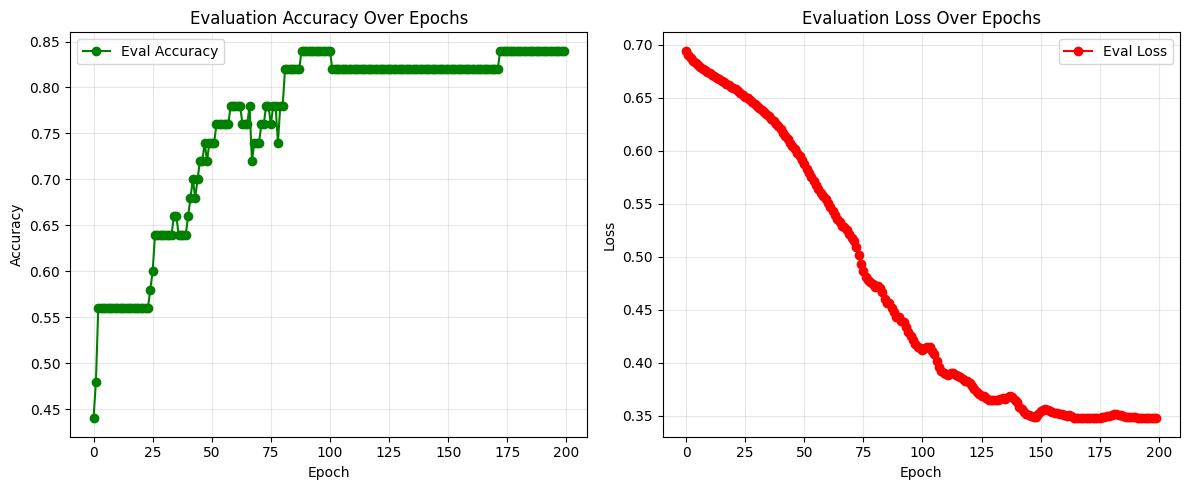


Final Results:
Final accuracy: 0.8400
Final loss: 0.3482

Script execution completed!

SUMMARY OF CHANGES FROM ORIGINAL QLORA:
✅ Removed all quantization-related imports
✅ Removed BitsAndBytesConfig
✅ Removed prepare_model_for_kbit_training()
✅ Removed replace_lora_weights_loftq()
✅ Using standard AutoModelForSequenceClassification
✅ Using regular LoRA instead of QLoRA
✅ Compatible with CPU and any GPU
✅ No dependency on bitsandbytes or triton


In [24]:
# -*- coding: utf-8 -*-
"""LoRA with Hugging Face (No Quantization)

Modified from original QLoRA notebook to remove all quantization.
This version uses standard LoRA without 4-bit or 8-bit quantization.
"""

# Install required libraries (without bitsandbytes and triton)
# !pip install -U datasets==2.20.0 huggingface_hub==0.23.4 transformers==4.41.2 peft==0.11.1 matplotlib==3.9.0 scikit-learn==1.5.0

# Import required libraries
#import torch
#import matplotlib.pyplot as plt

# Suppress warnings
#def warn(*args, **kwargs):
#    pass
#import warnings
#warnings.warn = warn
#warnings.filterwarnings('ignore')

#import json
#import numpy as np

#from datasets import load_dataset, load_metric
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
#from peft import LoraConfig, get_peft_model, TaskType

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define helper functions
def save_to_json(data, file_path):
    """
    Save a dictionary to a JSON file.

    Args:
        data (dict): The dictionary to save.
        file_path (str): The path to the JSON file.
    """
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    print(f"Data successfully saved to {file_path}")

def load_from_json(file_path):
    """
    Load data from a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The data loaded from the JSON file.
    """
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    return data

# Load IMDB dataset
print("Loading IMDB dataset...")
imdb = load_dataset("imdb")

# Display the structure of the dataset
print("Dataset structure:")
print(imdb)

# Display available splits
print("\nAvailable splits:")
print(imdb.keys())

# Explore and print a sample from the training set
print("\nSample from the training set:")
print(imdb['train'][0])

# Display unique class labels
train_labels = imdb['train']['label']
unique_labels = set(train_labels)
print("\nUnique labels in the dataset (class information):")
print(unique_labels)

# Class names mapping
class_names = {0: "negative", 1: "positive"}
print("Class names:", class_names)

# Create smaller subsets for faster training and testing
print("\nCreating dataset subsets...")
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(50))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(50))])
medium_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
medium_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

# Load the DistilBERT tokenizer
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Example tokenization
my_tokens = tokenizer(imdb['train'][0]['text'])

# Print the tokenized input IDs (first 20 tokens only for brevity)
print("Input IDs (first 20):", my_tokens['input_ids'][:20])
print("Attention Mask (first 20):", my_tokens['attention_mask'][:20])

# If token_type_ids is present, print it
if 'token_type_ids' in my_tokens:
    print("Token Type IDs (first 20):", my_tokens['token_type_ids'][:20])

# Preprocessing function for tokenization
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

print("Tokenizing datasets...")
small_tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
small_tokenized_test = small_test_dataset.map(preprocess_function, batched=True)
medium_tokenized_train = medium_train_dataset.map(preprocess_function, batched=True)
medium_tokenized_test = medium_test_dataset.map(preprocess_function, batched=True)

# Display tokenized sample
print("\nTokenized sample (keys only):")
print("Keys:", list(small_tokenized_train[0].keys()))

# Define compute_metrics function to evaluate model performance using accuracy
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy", trust_remote_code=True)

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"accuracy": accuracy}

# Create label mappings
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = dict((v,k) for k,v in id2label.items())


# Load model WITHOUT quantization
print("Loading model without quantization...")
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    id2label=id2label,
    label2id=label2id,
    num_labels=2
)

# Move model to device
model = model.to(device)
print(f"Model moved to {device}")

# Configure LoRA (without any quantization)
print("Configuring LoRA...")
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Specify the task type as sequence classification
    r=8,  # Rank of the low-rank matrices
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout rate
    target_modules=['q_lin', 'k_lin', 'v_lin']  # Which modules to target
)

# Apply LoRA to the model
peft_model = get_peft_model(model, lora_config)

# Print model summary
print("\nModel summary:")
print(type(peft_model))

# Print trainable parameters
print("\nTrainable parameters:")
peft_model.print_trainable_parameters()

# Define training arguments
print("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./results_lora_no_quant",
    num_train_epochs=200,  # Reduced epochs for faster training
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True
)

# Create trainer
print("Creating trainer...")
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=small_tokenized_train,  # Using small dataset for demo
    eval_dataset=small_tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
print("Starting training...")
try:
    trainer.train()
    print("Training completed successfully!")
except Exception as e:
    print(f"Training failed with error: {e}")

# Save the trained model
try:
    trainer.save_model("./lora_final_model_no_quant")
    print("Model saved successfully!")
except Exception as e:
    print(f"Failed to save model: {e}")

# Extract training history for analysis
try:
    log_history = trainer.state.log_history

    # Function to extract metrics from log history
    get_metric = lambda metric, log_history: [log[metric] for log in log_history if metric in log]

    # Extract evaluation metrics
    eval_accuracy = get_metric('eval_accuracy', log_history)
    eval_loss = get_metric('eval_loss', log_history)

    # Plot training progress if we have data
    if eval_accuracy and eval_loss:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(eval_accuracy, label='Eval Accuracy', marker='o', color='green')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Evaluation Accuracy Over Epochs")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(eval_loss, label='Eval Loss', marker='o', color='red')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Evaluation Loss Over Epochs")
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('./training_progress.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print final results
        print(f"\nFinal Results:")
        print(f"Final accuracy: {eval_accuracy[-1]:.4f}")
        print(f"Final loss: {eval_loss[-1]:.4f}")
    else:
        print("No evaluation metrics found in log history")

except Exception as e:
    print(f"Error during results analysis: {e}")

print("\nScript execution completed!")

# Summary of changes made:
print("\n" + "="*50)
print("SUMMARY OF CHANGES FROM ORIGINAL QLORA:")
print("="*50)
print("✅ Removed all quantization-related imports")
print("✅ Removed BitsAndBytesConfig")
print("✅ Removed prepare_model_for_kbit_training()")
print("✅ Removed replace_lora_weights_loftq()")
print("✅ Using standard AutoModelForSequenceClassification")
print("✅ Using regular LoRA instead of QLoRA")
print("✅ Compatible with CPU and any GPU")
print("✅ No dependency on bitsandbytes or triton")
print("="*50)

The above code results in the following plot:

![qlora_training_plot](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/wzMMj73IuM6fKmPZtKtQNA/qlora-training-plot.png)


The above code indicates that, in this particular instance, the bulk of the benefits from fine-tuning were gained within the first 3 epochs.


---


## Congratulations! You have completed the lab


## Authors


[Wojciech "Victor" Fulmyk](https://www.linkedin.com/in/wfulmyk) is a Data Scientist and a PhD Candidate in Economics at the University of Calgary.


[Fateme Akbari](https://www.linkedin.com/in/fatemeakbari/) is a Ph.D. candidate in Information Systems at McMaster University with demonstrated research experience in Machine Learning and NLP.


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


## References

[Finetuning with LoRA -- A Hands-On Example](https://lightning.ai/lightning-ai/studios/code-lora-from-scratch)

[QLORA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/pdf/2305.14314)

[Making LLMs even more accessible with bitsandbytes, 4-bit quantization and QLoRA](https://huggingface.co/blog/4bit-transformers-bitsandbytes)


## Change Log


|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2024-07-09|0.99|Victor|Lab written|


Copyright © 2024 IBM Corporation. All rights reserved.
